In [1]:
from cleaner.cleaner import Cleaner
from utils.utils import Utils
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor

In [2]:
df = Cleaner.clean_data()

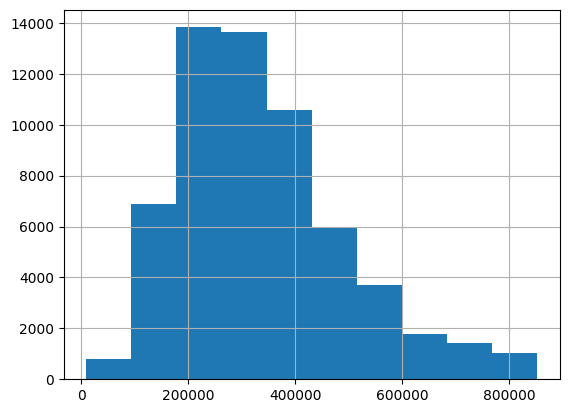

In [3]:
numerical_features = ["bedroomCount", "habitableSurface", "facedeCount", "streetFacadeWidth", "kitchenSurface", "landSurface", 
                      "terraceSurface", "gardenSurface", "toiletCount", "bathroomCount"]
categorical_features = [
    "type",
    "subtype",
    "province",
    "locality",
    "postCode",
    "hasBasement",
    "buildingCondition",
    "buildingConstructionYear",
    "hasTerrace",
    "floodZoneType",
    "heatingType",
    "kitchenType",
    "gardenOrientation",
    "hasSwimmingPool",
    
    "terraceOrientation",
    "epcScore"
]

'''
gardenOrientation           55192
terraceOrientation          50584
parkingCountOutdoor         45827
parkingCountIndoor          38379
floodZoneType               25696
kitchenType                 25307
heatingType                 21571
buildingCondition           13869
epcScore                     8798
'''

target_name = "price"

X = df[numerical_features + categorical_features]
y = df[target_name]

_ = y.hist()

In [4]:
categorical_preprocessors = [
    ("drop", "drop"),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    (
        "one_hot",
        OneHotEncoder(handle_unknown="ignore", max_categories=20, sparse_output=False),
    ),
    ("target", TargetEncoder(target_type="continuous")),
]

In [5]:
n_cv_folds = 5
max_iter = 20
results = []

for name, categorical_preprocessor in categorical_preprocessors:
    preprocessor = ColumnTransformer(
        [
            ("numerical", "passthrough", numerical_features),
            ("categorical", categorical_preprocessor, categorical_features),
        ]
    )
    pipe = make_pipeline(
        preprocessor, HistGradientBoostingRegressor(random_state = 0, max_iter = max_iter)
    )
    results = Utils.evaluate_model_and_store(X, y, name, pipe, res = results)

In [6]:
print(results)

[{'preprocessor': 'drop', 'mae_test_mean': np.float64(94374.70727187648), 'mae_test_std': np.float64(8670.190064903454), 'mae_train_mean': np.float64(89451.34252303041), 'mae_train_std': np.float64(1080.9157755081105)}, {'preprocessor': 'ordinal', 'mae_test_mean': np.float64(79254.08982071595), 'mae_test_std': np.float64(9325.739186113562), 'mae_train_mean': np.float64(68315.21648367579), 'mae_train_std': np.float64(1119.023951509332)}, {'preprocessor': 'one_hot', 'mae_test_mean': np.float64(83550.35698539307), 'mae_test_std': np.float64(10813.857716823), 'mae_train_mean': np.float64(71025.12280472815), 'mae_train_std': np.float64(851.7890045216329)}, {'preprocessor': 'target', 'mae_test_mean': np.float64(75253.26030182574), 'mae_test_std': np.float64(5645.1940364472985), 'mae_train_mean': np.float64(63664.62193334427), 'mae_train_std': np.float64(657.8009616120743)}]


In [7]:
n_unique_categories = df[categorical_features].nunique().sort_values(ascending=False)
n_unique_categories

high_cardinality_features = n_unique_categories[n_unique_categories > 255].index
low_cardinality_features = n_unique_categories[n_unique_categories <= 255].index
high_cardinality_features, low_cardinality_features

(Index(['locality', 'postCode'], dtype='object'),
 Index(['buildingConstructionYear', 'subtype', 'province', 'floodZoneType',
        'epcScore', 'gardenOrientation', 'terraceOrientation', 'kitchenType',
        'heatingType', 'buildingCondition', 'hasBasement', 'type', 'hasTerrace',
        'hasSwimmingPool'],
       dtype='object'))

In [8]:
mixed_encoded_preprocessor = ColumnTransformer(
    [
        ("numerical", "passthrough", numerical_features),
        (
            "high_cardinality",
            TargetEncoder(target_type="continuous"),
            high_cardinality_features
        ),
        (
            "low_cardinality",
            OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1),
            low_cardinality_features
        )
    ],
    verbose_feature_names_out = False
)

# The output of the of the preprocessor must be set to pandas so the
# gradient boosting model can detect the low cardinality features.
mixed_encoded_preprocessor.set_output(transform = "pandas")
mixed_pipe = make_pipeline(
    mixed_encoded_preprocessor,
    HistGradientBoostingRegressor(
        random_state = 0, max_iter = max_iter, categorical_features =low_cardinality_features
    )
)
mixed_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['bedroomCount',
                                                   'habitableSurface',
                                                   'facedeCount',
                                                   'streetFacadeWidth',
                                                   'kitchenSurface',
                                                   'landSurface',
                                                   'terraceSurface',
                                                   'gardenSurface',
                                                   'toiletCount',
                                                   'bathroomCount']),
                                                 ('high_cardinality',
                                                  TargetEncoder(target_type='continuous'),
                                                  Index(['locality', 'postCode']...
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=Index(['buildingConstructionYear', 'subtype', 'province', 'floodZoneType',
       'epcScore', 'gardenOrientation', 'terraceOrientation', 'kitchenType',
       'heatingType', 'buildingCondition', 'hasBasement', 'type', 'hasTerrace',
       'hasSwimmingPool'],
      dtype='object'),
                                               max_iter=20, random_state=0))])

In [9]:
results = Utils.evaluate_model_and_store(X, y, "mixed_target", mixed_pipe, res = results)

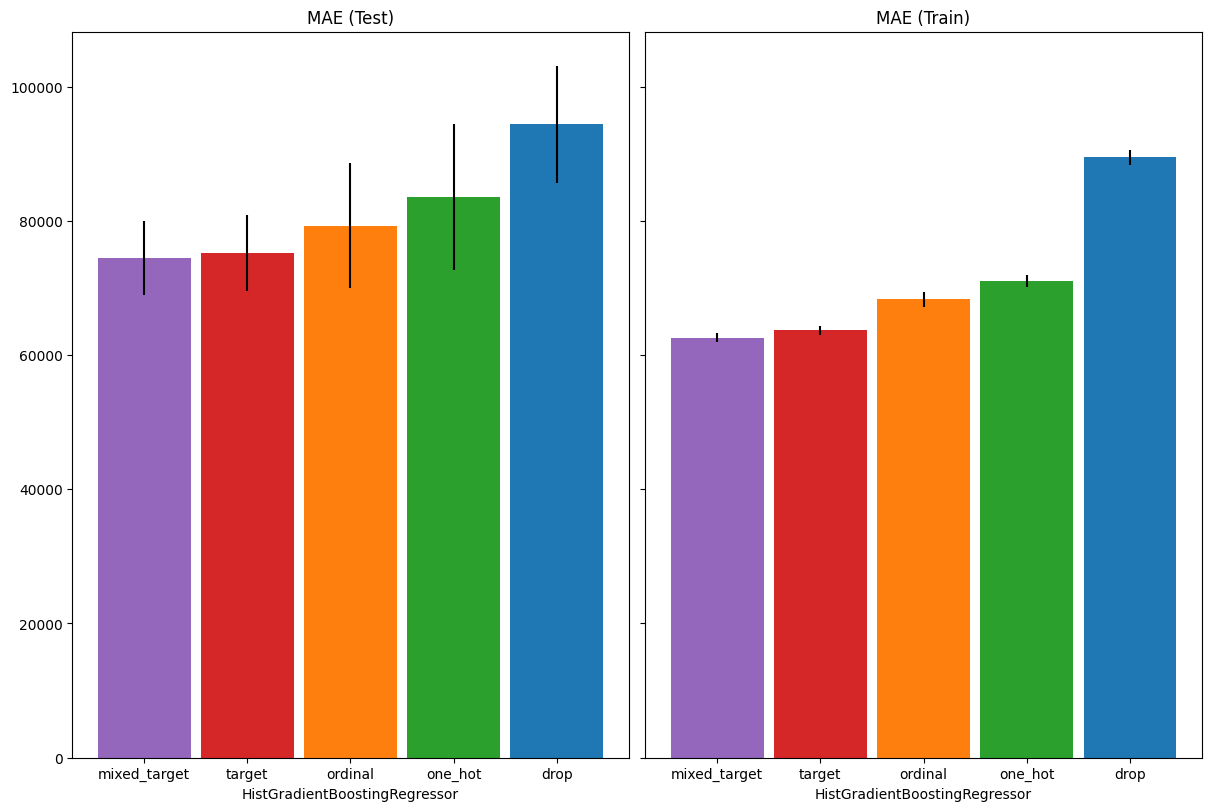

In [10]:
Utils.visualize_results(results, 'HistGradientBoostingRegressor')

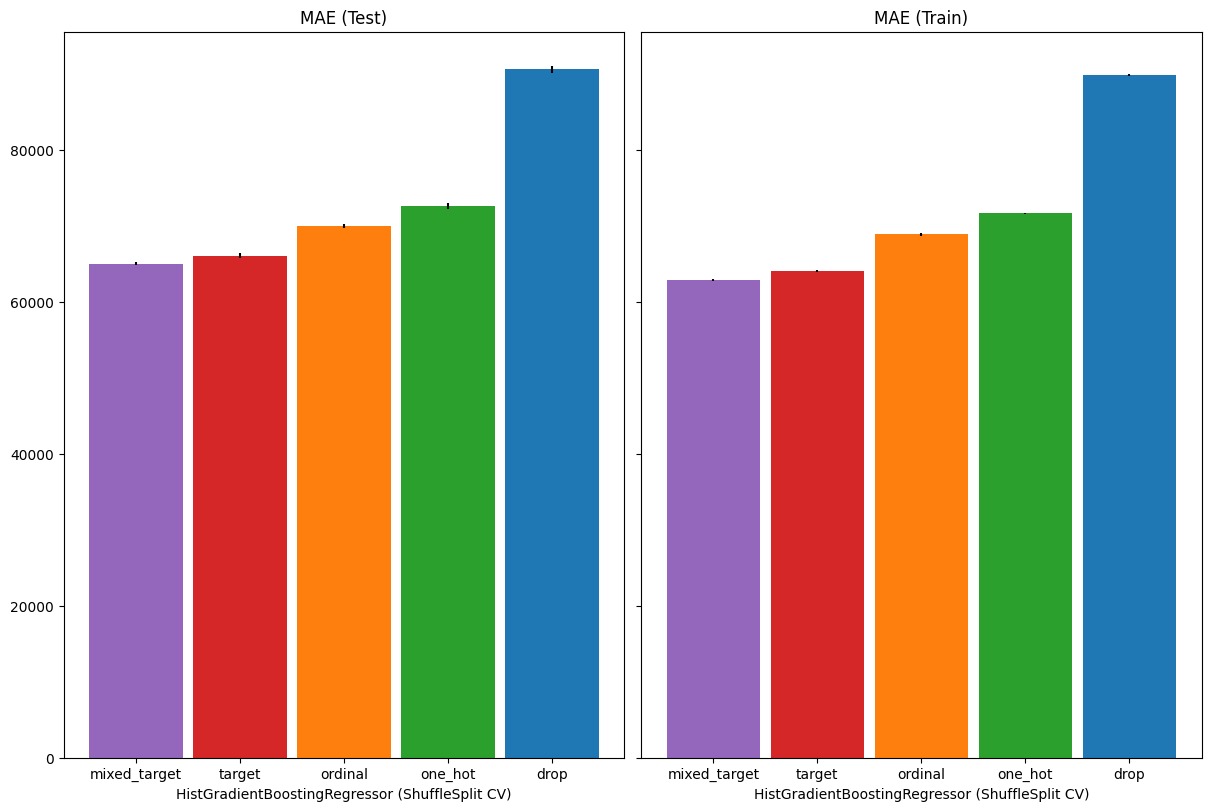

In [ ]:
cv_shuffle_split = ShuffleSplit(n_splits = n_cv_folds, test_size = 0.25, random_state = 0)
results = []
for name, categorical_preprocessor in categorical_preprocessors:
    preprocessor = ColumnTransformer(
        [
            ("numerical", "passthrough", numerical_features),
            ("categorical", categorical_preprocessor, categorical_features),
        ]
    )
    pipe = make_pipeline(
        preprocessor, HistGradientBoostingRegressor(random_state = 0, max_iter = max_iter)
    )
    results = Utils.evaluate_model_and_store(X, y, name, pipe, cv_shuffle_split, res = results)

results = Utils.evaluate_model_and_store(X, y, "mixed_target", mixed_pipe, cv_shuffle_split, res = results)

Utils.visualize_results(results, 'HistGradientBoostingRegressor (ShuffleSplit CV)')

In [ ]:
RF_pipe = make_pipeline(
    mixed_encoded_preprocessor,
    RandomForestRegressor(
        random_state = 0, criterion = 'absolute_error', n_estimators = 200
    )
)

Utils.evaluate_model_and_store(X, y, 'RF_mixed', RF_pipe)

In [ ]:
import joblib

N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")
df.isnull().sum().sort_values(ascending=False).head(20)
